In [1]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, MultiPolygon
import warnings
from sklearn.metrics import mean_squared_error

# Overview
This code finds the contact angle of one frame of the video that was processed in Matlab. In this particular example we will find the angle for the i=701st frame. This value can be changed to be any of the frames. 

# 1) Data Load

In [4]:
data = scipy.io.loadmat('C:\\Users\josep\Desktop\Summer Research Project\processed_edges_Matlab.mat') 
# Processed Edges from the edge processing in Matlab

processed_edges = data['processedEdges'] 
# Extract the frames 

In [5]:
processed_edges[0,0].shape

(1080, 1721)

In [6]:
i = 701

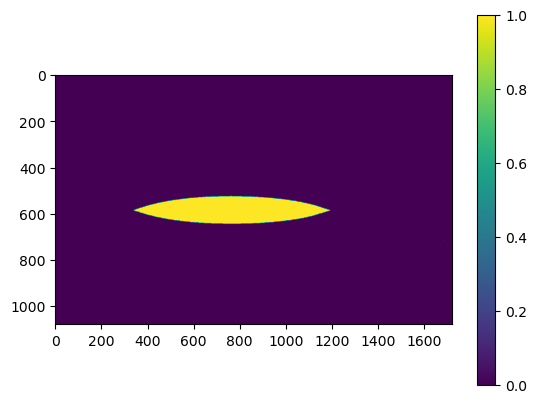

In [7]:
plt.imshow(processed_edges[0, i], cmap='viridis')  
plt.colorbar()  
plt.show()

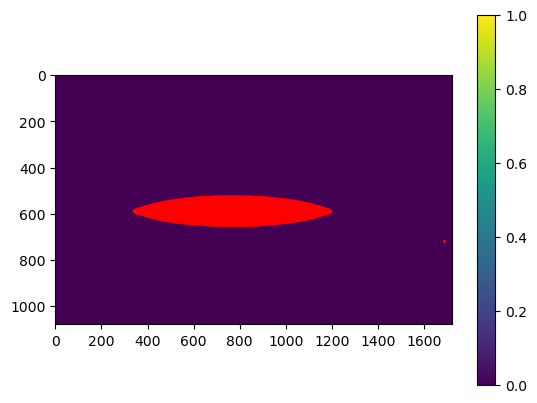

In [8]:
# Extract the 2D array
data = processed_edges[0, i]

# Indices where values are greater than 0.8 as this image is processed as a spectrum represented by the 
# colours in the z direction
y, x = np.where(data > 0.8)

plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.scatter(x, y, color='red', s=2)

plt.show()

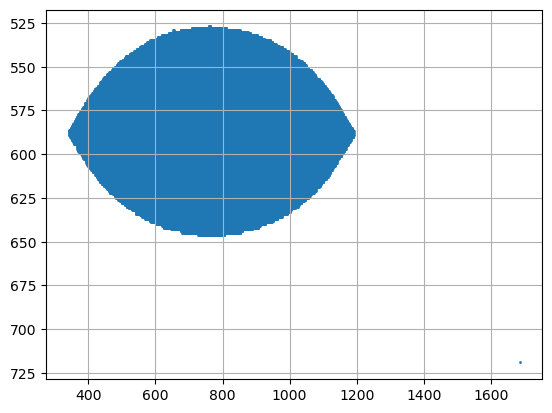

In [9]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

## 1.1) Find Middle Line
We need to find the middle line that divides the droplet into the actual droplet and the droplet reflection. Due to the form of the Matlab data the quickest way to do it was by eye. I played around with different methods of finding it but to keep it simple I left it by eye. 

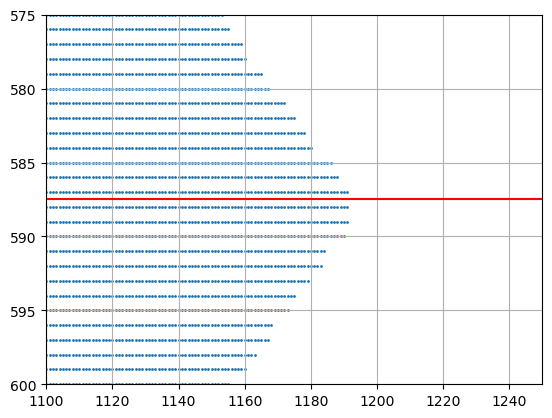

In [11]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()
plt.xlim(1100, 1250)
plt.ylim(600, 575)
plt.axhline(y=587.5, color='r', linestyle='-')
plt.show()

In [12]:
y_line = 587.5

## 1.2) Upper Half

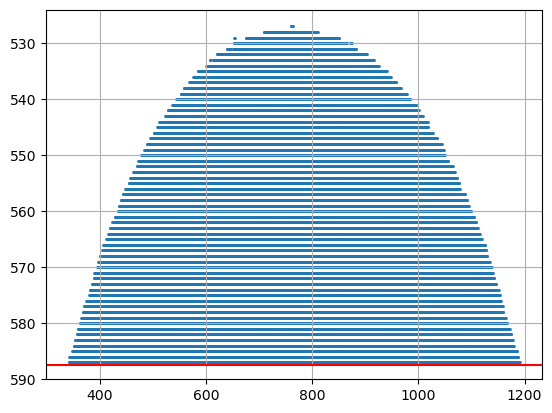

In [14]:
x_filtered = x[y <= y_line]
y_filtered = y[y <= y_line]

plt.figure()
plt.scatter(x_filtered, y_filtered, s=1)
plt.grid(True)
plt.gca().invert_yaxis()
#plt.ylim(400, -200)

plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

# 2) Left Side

## 2.1) Find Edge of Data

In [17]:
half_point = (-np.min(x_filtered) + np.max(x_filtered)) / 4 + np.min(x_filtered)
# Just consider the lower quarter of the left side. 

half_point

554.25

In [18]:
half_mask = [x_filtered <= half_point][0]

In [19]:
x_half = x_filtered[half_mask]
y_half = y_filtered[half_mask]

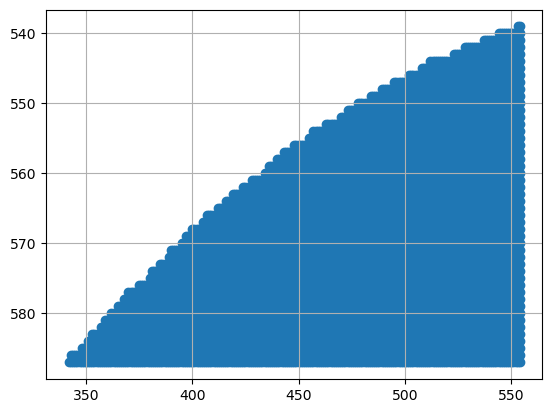

In [20]:
plt.scatter(x_half, y_half)
plt.grid(True)
plt.gca().invert_yaxis()

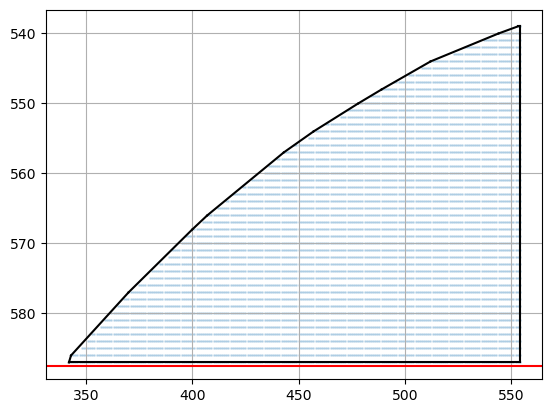

In [21]:
x_filtered = x_half[y_half <= y_line]
y_filtered = y_half[y_half <= y_line]

# Find the convex hull. This method is fairly computationally expensive which is why I only considered the lower quarter of the data. 
points = np.vstack((x_filtered, y_filtered)).T
hull = ConvexHull(points)

plt.figure()
plt.scatter(x_filtered, y_filtered, s=1, alpha=0.2)  # Plot all points with low opacity

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', lw=1.5)  # Edge of the shape

plt.grid(True)
plt.gca().invert_yaxis()
plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

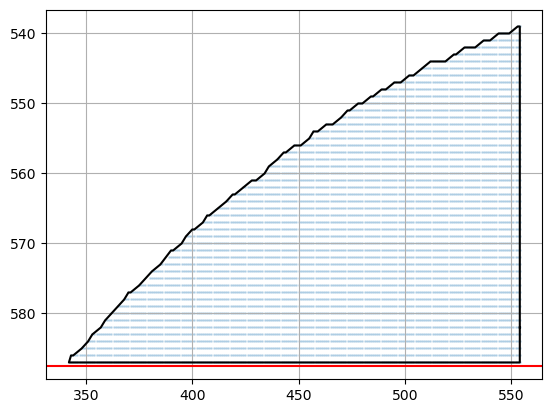

In [22]:
x_filtered = x_half[y_half <= y_line]
y_filtered = y_half[y_half <= y_line]

# Create points array. This method is fairly computationally expensive which is why I only considered the lower quarter of the data. 
points = np.vstack((x_filtered, y_filtered)).T

# Compute the alpha shape with a suitable alpha value
alpha = 0.1  #
alpha_shape = alphashape.alphashape(points, alpha)

# Plot the alpha shape
plt.figure()
plt.scatter(x_filtered, y_filtered, s=1, alpha=0.2)  
# Check if the alpha shape is a Polygon or MultiPolygon and plot accordingly
if isinstance(alpha_shape, Polygon):
    x_edge, y_edge = alpha_shape.exterior.xy
    plt.plot(x_edge, y_edge, 'k-', lw=1.5)
elif isinstance(alpha_shape, MultiPolygon):
    for poly in alpha_shape:
        x_edge, y_edge = poly.exterior.xy
        plt.plot(x_edge, y_edge, 'k-', lw=1.5)

plt.grid(True)
plt.gca().invert_yaxis()
plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

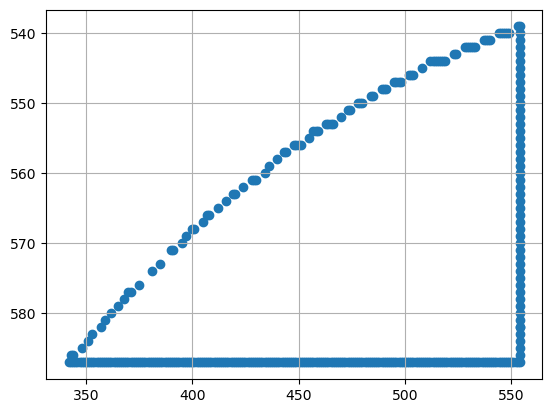

In [23]:
plt.scatter(x_edge, y_edge)
plt.grid(True)
plt.gca().invert_yaxis()

## 2.2) Remove Corner Section

In [25]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    
    Parameters:
    x_edge (list): List of x coordinates.
    y_edge (list): List of y coordinates.
    target_y (int or float): The y value to filter the x values.
    """
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]
        
    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

target_y = 587

In [26]:
x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, target_y)

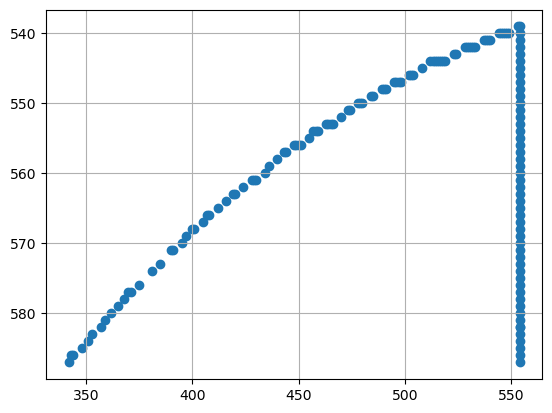

In [27]:
plt.scatter(x_main_edge, y_main_edge)
plt.grid(True)
plt.gca().invert_yaxis()

In [28]:
mask_middle = np.where( np.isclose(x_main_edge, half_point, atol= 1.5) )

In [29]:
#Get all indices
all_indices = np.arange(x_main_edge.shape[0])

# Get indices that are not in mask_middle
ind_not_middle = np.setdiff1d(all_indices, mask_middle)

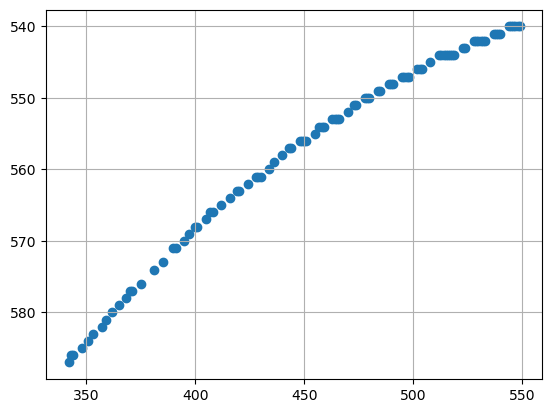

In [30]:
plt.scatter(x_main_edge[ind_not_middle], y_main_edge[ind_not_middle])
plt.grid(True)
plt.gca().invert_yaxis()

## 2.3) Perform Iterative Fitting

In [32]:
x_half = x_main_edge[ind_not_middle]
y_half = y_main_edge[ind_not_middle]

In [33]:
from collections import defaultdict

# Remove duplicates to improve fitting
y_to_x = defaultdict(list)
for x, y in zip(x_half, y_half):
    y_to_x[y].append(x)

unique_y = np.array(sorted(y_to_x.keys()))
unique_x = np.array([np.mean(y_to_x[y]) for y in unique_y])

In [34]:
no_of_points = 20

x_edge_points = unique_x[-no_of_points:]
y_edge_points = unique_y[-no_of_points:]

# Find the index of the maximum x value
max_y_index = np.argmax(y_edge_points)
max_x_point = x_edge_points[max_y_index]
max_y_point = y_edge_points[max_y_index]

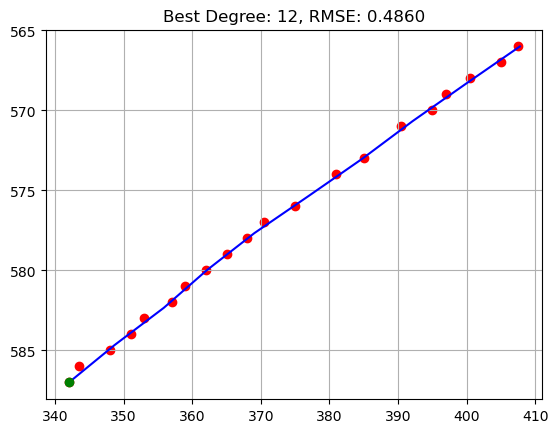

In [35]:
best_degree = 0
best_rmse = float('inf')
best_poly = None

# Iterate through polynomial degrees from 0 to 12
for degree in range(13):

    # Suppress the RankWarning for poorly conditioned polynomial fit
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        
        coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
    
    # Adjust the polynomial to pass through the (max_y_point, max_x_point)
    poly = np.poly1d(coeffs)

    x_at_max_y = poly(max_y_point)
    adjustment = max_x_point - x_at_max_y

    coeffs[-1] += adjustment
    poly_adjusted = np.poly1d(coeffs)

    # Calculate the RMSE for the current polynomial
    x_pred = poly_adjusted(y_edge_points)
    rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))

    # Update the best degree and polynomial if the current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree
        best_poly = poly_adjusted

# Create the fitted polynomial line using the best polynomial
y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
x_fit = best_poly(y_fit)

plt.scatter(x_edge_points, y_edge_points, color='red', zorder=1)
plt.plot(x_fit, y_fit, color='blue', zorder=2)
plt.scatter(max_x_point, max_y_point, color='green', zorder=3)
plt.gca().invert_yaxis()
plt.grid(True)

plt.title(f'Best Degree: {best_degree}, RMSE: {best_rmse:.4f}')
plt.show()

In [36]:
index_min_x = np.argmax(y_fit)
y_at_min_x = y_fit[index_min_x]
index_min_x, y_at_min_x

(9, 587.0)

## 2.4) Find Angle

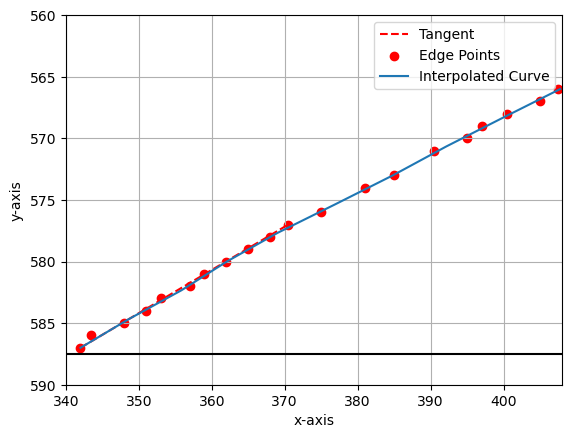

In [38]:
# calculate the derivative at the point
if index_min_x==0:
    dx_new = x_fit[0]-x_fit[1]

if index_min_x > 0:
    dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]

if dx_new>0:
    dx = -dx_new
if dx_new<0:
    dx = np.abs(dx_new)

dy_dx = np.gradient(y_fit, dx)
slope_at_min_x1 = dy_dx[index_min_x]

# tangent line
y_tangent1 = np.linspace(max(y_fit), max(y_fit)-10, 100)
x_tangent1 = ( 1/slope_at_min_x1 ) * (y_tangent1 - y_fit[index_min_x]) + x_fit[index_min_x]

plt.plot(x_tangent1, y_tangent1, color='red', linestyle='--', label='Tangent') 
plt.scatter(unique_x, unique_y, color = 'red', zorder=1, label='Edge Points')
plt.grid(True)
plt.plot(x_fit, y_fit, label='Interpolated Curve')

plt.legend()
plt.gca().invert_yaxis()
plt.xlabel("x-axis")
plt.ylabel("y-axis")

plt.xlim(340, 408)
plt.ylim(590, 560)
plt.axhline(y=y_line, color='black', linestyle='-')

plt.show()

In [39]:
angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
# Measure angle on right side of interpolation 

if angle_tangent_degrees_left<0:
    angle = np.abs(angle_tangent_degrees_left)

if angle_tangent_degrees_left>0:
    angle = 180 - angle_tangent_degrees_left

In [40]:
angle

19.342960643121987

# 3) Right Side

## 3.1) Find Edge of Data

In [43]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

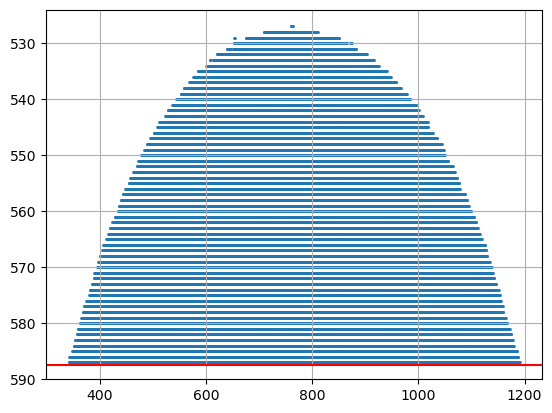

In [44]:
x_filtered = x[y <= y_line]
y_filtered = y[y <= y_line]

plt.figure()
plt.scatter(x_filtered, y_filtered, s=1)
plt.grid(True)
plt.gca().invert_yaxis()
plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

In [45]:
half_point = -(-np.min(x_filtered) + np.max(x_filtered)) / 4 + np.max(x_filtered)
half_point

978.75

In [46]:
half_mask = [x_filtered >= half_point][0]

In [47]:
x_half = x_filtered[half_mask]
y_half = y_filtered[half_mask]

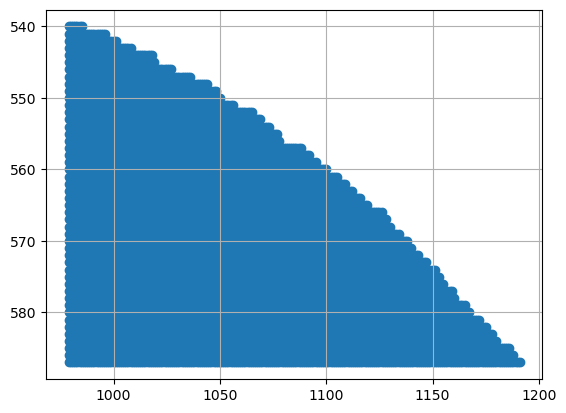

In [48]:
plt.scatter(x_half, y_half)
plt.grid(True)
plt.gca().invert_yaxis()

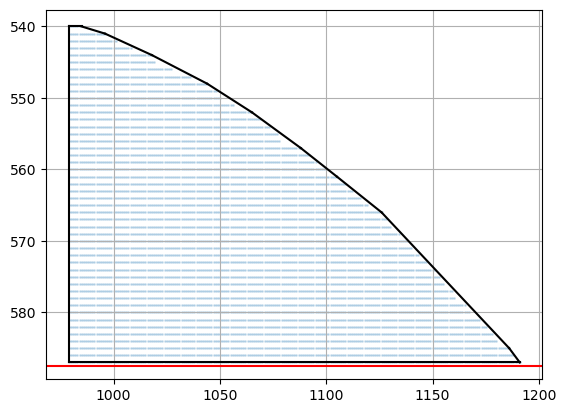

In [49]:
x_filtered = x_half[y_half <= y_line]
y_filtered = y_half[y_half <= y_line]

# Find the convex hull
points = np.vstack((x_filtered, y_filtered)).T
hull = ConvexHull(points)

plt.figure()
plt.scatter(x_filtered, y_filtered, s=1, alpha=0.2)  # Plot all points with low opacity

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', lw=1.5)  # Edge of the shape

plt.grid(True)
plt.gca().invert_yaxis()
plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

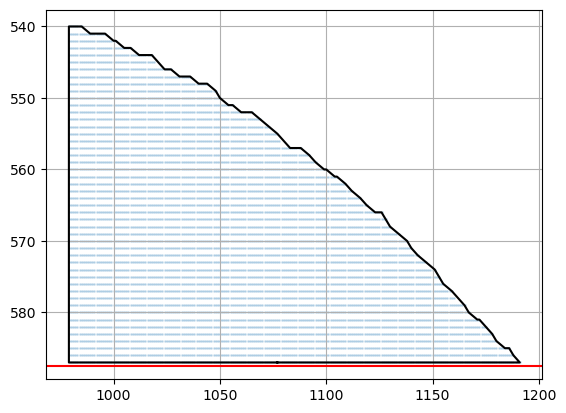

In [50]:
x_filtered = x_half[y_half <= y_line]
y_filtered = y_half[y_half <= y_line]

points = np.vstack((x_filtered, y_filtered)).T

# Compute the alpha shape with a suitable alpha value
alpha = 0.1  #
alpha_shape = alphashape.alphashape(points, alpha)

# Plot the alpha shape
plt.figure()
plt.scatter(x_filtered, y_filtered, s=1, alpha=0.2)  
# Check if the alpha shape is a Polygon or MultiPolygon and plot accordingly
if isinstance(alpha_shape, Polygon):
    x_edge, y_edge = alpha_shape.exterior.xy
    plt.plot(x_edge, y_edge, 'k-', lw=1.5)
elif isinstance(alpha_shape, MultiPolygon):
    for poly in alpha_shape:
        x_edge, y_edge = poly.exterior.xy
        plt.plot(x_edge, y_edge, 'k-', lw=1.5)

plt.grid(True)
plt.gca().invert_yaxis()
plt.axhline(y=y_line, color='r', linestyle='-')
plt.show()

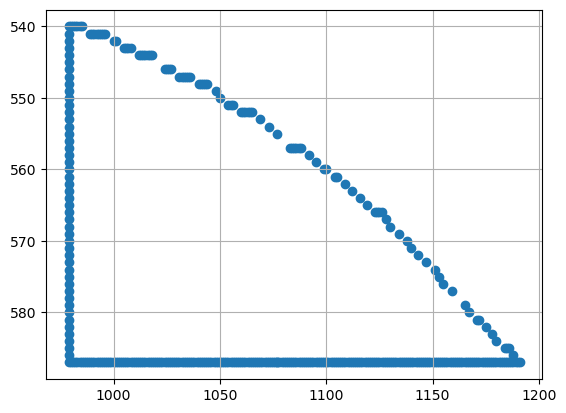

In [51]:
plt.scatter(x_edge, y_edge)
plt.grid(True)
plt.gca().invert_yaxis()

In [52]:
target_y

587

## 3.2) Remove Corner Section

In [54]:
x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, target_y)

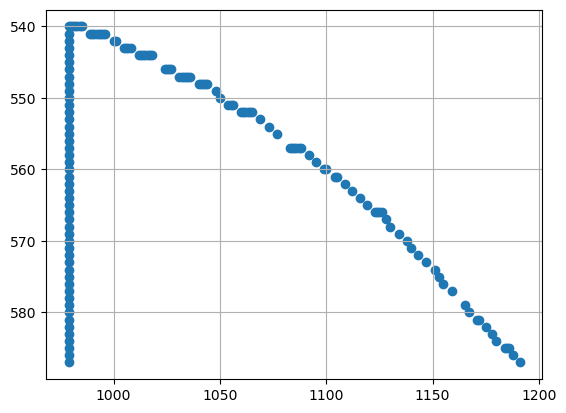

In [55]:
plt.scatter(x_main_edge, y_main_edge)
plt.grid(True)
plt.gca().invert_yaxis()

In [56]:
mask_middle = np.where( np.isclose(x_main_edge, half_point, atol= 1.5) )

#Get all indices
all_indices = np.arange(x_main_edge.shape[0])

# Get indices that are not in mask_middle
ind_not_middle = np.setdiff1d(all_indices, mask_middle)

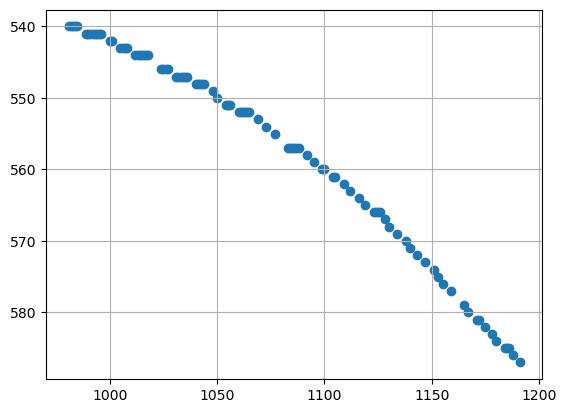

In [57]:
plt.scatter(x_main_edge[ind_not_middle], y_main_edge[ind_not_middle])
plt.grid(True)
plt.gca().invert_yaxis()

## 3.3) Perform Iterative Fitting

In [59]:
x_half = x_main_edge[ind_not_middle]
y_half = y_main_edge[ind_not_middle]

In [60]:
# Alternatively, you can average the y values for duplicate x values
from collections import defaultdict

y_to_x = defaultdict(list)
for x, y in zip(x_half, y_half):
    y_to_x[y].append(x)

unique_y = np.array(sorted(y_to_x.keys()))
unique_x = np.array([np.mean(y_to_x[y]) for y in unique_y])

In [61]:
no_of_points = 20

x_edge_points = unique_x[-no_of_points:]
y_edge_points = unique_y[-no_of_points:]

In [62]:
# Find the index of the maximum x value
max_y_index = np.argmax(y_edge_points)
max_x_point = x_edge_points[max_y_index]
max_y_point = y_edge_points[max_y_index]

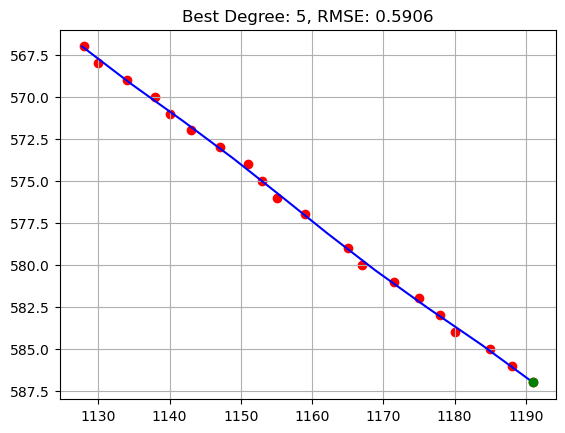

In [63]:
best_degree = 0
best_rmse = float('inf')
best_poly = None

# Iterate through polynomial degrees from 0 to 12
for degree in range(13):
    # Suppress the RankWarning for poorly conditioned polynomial fit
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
    
    # Adjust the polynomial to pass through the (max_y_point, max_x_point)
    poly = np.poly1d(coeffs)
    x_at_max_y = poly(max_y_point)
    adjustment = max_x_point - x_at_max_y

    # Create the adjusted polynomial
    coeffs[-1] += adjustment
    poly_adjusted = np.poly1d(coeffs)

    # Calculate the RMSE for the current polynomial
    x_pred = poly_adjusted(y_edge_points)
    rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))

    # Update the best degree and polynomial if the current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_degree = degree
        best_poly = poly_adjusted

# Create the fitted polynomial line using the best polynomial
y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
x_fit = best_poly(y_fit)

plt.scatter(x_edge_points, y_edge_points, color='red', zorder=1)
plt.plot(x_fit, y_fit, color='blue', zorder=2)
plt.scatter(max_x_point, max_y_point, color='green', zorder=3)
plt.gca().invert_yaxis()
plt.grid(True)
plt.title(f'Best Degree: {best_degree}, RMSE: {best_rmse:.4f}')
plt.show()

In [64]:
index_min_x = np.argmax(y_fit)
y_at_min_x = y_fit[index_min_x]
index_min_x, y_at_min_x

(9, 587.0)

## 3.4) Find Angle

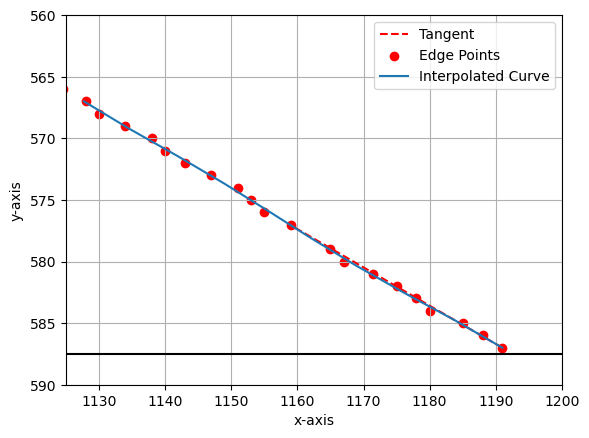

In [66]:
# calculate the derivative at the point
if index_min_x==0:
    dx_new = x_fit[0]-x_fit[1]

if index_min_x > 0:
    dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]

if dx_new>0:
    dx = -dx_new
if dx_new<0:
    dx = np.abs(dx_new)

dy_dx = np.gradient(y_fit, dx)
slope_at_min_x1 = dy_dx[index_min_x]

# tangent line
y_tangent1 = np.linspace(max(y_fit), max(y_fit)-10, 10)
x_tangent1 = ( 1/slope_at_min_x1 ) * (y_tangent1 - y_fit[index_min_x]) + x_fit[index_min_x]

plt.plot(x_tangent1, y_tangent1, color='red', linestyle='--', label='Tangent') 
plt.scatter(unique_x, unique_y, color = 'red', zorder=1,  label='Edge Points')
plt.grid(True)
plt.plot(x_fit, y_fit, label='Interpolated Curve')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(1125, 1200)
plt.ylim(590, 560)
plt.axhline(y=y_line, color='black', linestyle='-')
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

In [67]:
angle_tangent_degrees_right  = np.degrees(np.arctan(slope_at_min_x1))
# Measure angle on right side of interpolation 

if angle_tangent_degrees_right < 0:
    angle = 180 + angle_tangent_degrees_right

if angle_tangent_degrees_right > 0:
    angle = angle_tangent_degrees_right

In [68]:
angle

17.258575766268066